Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1734 - val_loss: 0.0490
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0613 - val_loss: 0.0451
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0546 - val_loss: 0.0465
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0571 - val_loss: 0.0452
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0586 - val_loss: 0.0456
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0621 - val_loss: 0.0451
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0519 - val_loss: 0.0446
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0522 - val_loss: 0.0458
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0550 - val_loss: 0.0451
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0525 - val_loss: 0.0460
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0534 - val_loss: 0.0455
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0559 - val_loss: 0.0453

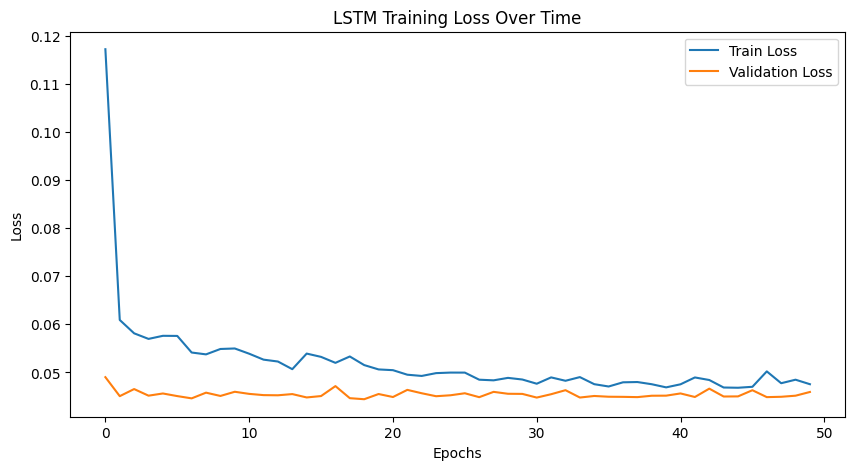

    Actual  Predicted
0      7.0   6.976643
1     21.0  14.063413
2     22.0  21.913198
3     30.0  30.145943
4     35.0  36.596619
5     39.0  43.251411
6      6.0   8.135183
7     30.0  15.389316
8     34.0  22.445211
9     45.0  29.082563
10    46.0  36.510044
11    48.0  43.605721
12     3.0   7.487968
13     6.0  14.414787
14     8.0  21.312960
15    11.0  28.308661
16    36.0  35.352840
17    48.0  42.462849
18     2.0   8.630301
19    11.0  15.863202
20    23.0  23.111967
21    24.0  29.456421
22    33.0  36.643604
23    44.0  43.480453
24     1.0   7.546970
25     4.0  14.542508
26     6.0  21.603865
27    15.0  28.578506
28    40.0  35.755096
29    44.0  42.813030


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv('./toto_cleaned_file.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Extract useful date-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.weekday  # Monday=0, Thursday=3

# Select relevant columns (winning numbers only)
winning_cols = [f'Winning Number {i}' for i in range(1, 7)]
data = df[winning_cols].copy()

# Normalize the data (LSTMs work better with scaled data)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences for LSTM (we predict next set based on last 10 draws)
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(data_scaled, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(6, activation='linear')  # Predicting 6 winning numbers
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict next draw
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Convert back to original scale

# Evaluate model
mse = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse}')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss Over Time')
plt.legend()
plt.show()

# Show a few predictions vs actual values
comparison = pd.DataFrame({'Actual': scaler.inverse_transform(y_test)[:5].flatten(),
                           'Predicted': y_pred_rescaled[:5].flatten()})
print(comparison)
